## Research Question
How is snowfall distributed across Massachusetts? Which areas get the most snow, and which get the least? Are there any aspects of the terrain that may cause these differences?

In [150]:
import pandas as pd
import geopandas as gpd
from scipy.interpolate import griddata
import numpy as np
import shapely

In [151]:
url = "https://www.ncdc.noaa.gov/snow-and-ice/daily-snow/MA-snowfall-{year}{month}.csv"
main_df = pd.read_csv(url.format(year="2015", month="12"), skiprows=1)
main_df.columns = [str(col) + (" 2015") if any(i.isdigit() for i in str(col)) else str(col) for col in main_df.columns]
for y in range(2016, 2022):
    for m in range(1, 13):
        if m > 8 and y == 2021:
            break
        if m >= 10:
            m = str(m)
        else:
            m = "0" + str(m)

        temp_df = pd.read_csv(url.format(year=y, month=m), skiprows=1)
        temp_df.columns = [str(col) + (' ' + str(y)) if any(i.isdigit() for i in str(col)) else str(col) for col in temp_df.columns]
        main_df = main_df.merge(temp_df, on='GHCN ID', how='left', suffixes=('', '_yx'))
        main_df = main_df.drop(main_df.filter(regex='_yx$').columns.tolist(), axis=1)

In [152]:
# Use this if website goes offline
# main_df = pd.read_pickle("snow_data.pkl")

In [153]:
snow_stations = gpd.GeoDataFrame(main_df, geometry=gpd.points_from_xy(main_df.Longitude, main_df.Latitude))

In [154]:
usa = gpd.read_file("https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_500k.zip")
MA = usa[usa.NAME == "Massachusetts"]

<AxesSubplot:>

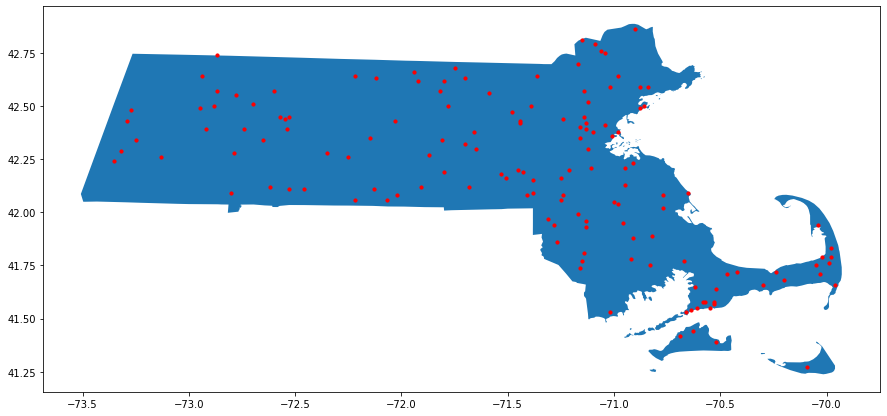

In [155]:
mass_plot = MA.plot(figsize=(15,15))
snow_stations.plot(ax=mass_plot, color="red", markersize=10)

In [156]:
snow_stations[list(snow_stations.columns[7:-2])] = snow_stations[list(snow_stations.columns[7:-2])].apply(pd.to_numeric, errors='coerce')
snow_stations = snow_stations.fillna(0)
snow_stations['total_snowfall'] = snow_stations[list(snow_stations.columns[7:-2])].sum(axis=1)

In [157]:
def get_cell_df(n_cells):
    # total area for the grid
    xmin, ymin, xmax, ymax= MA.total_bounds
    cell_size = (xmax-xmin)/n_cells
    # projection of the grid
    crs = "EPSG:4269"
    # create the cells in a loop
    mid_xs = []
    mid_ys = []
    grid_cells = []
    for x0 in np.arange(xmin, xmax+cell_size, cell_size ):
        for y0 in np.arange(ymin, ymax+cell_size, cell_size):
            # bounds
            x1 = x0-cell_size
            y1 = y0+cell_size
            grid_cells.append( shapely.geometry.box(x0, y0, x1, y1)  )
            mid_xs.append((x1+x0)/2)
            mid_ys.append((y1+y0)/2)
    return gpd.GeoDataFrame(grid_cells, columns=['geometry'], 
                                     crs=crs)

<AxesSubplot:>

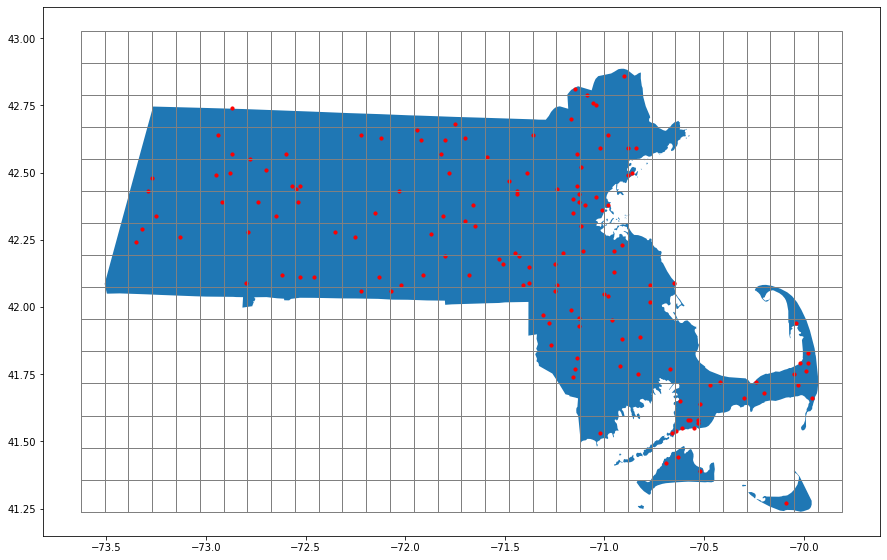

In [158]:
mass_plot = MA.plot(figsize=(15,15))
snow_stations.plot(ax=mass_plot, color="red", markersize=10)
get_cell_df(30).plot(ax=mass_plot, facecolor="none", edgecolor='grey')

In [159]:
def get_interp_cell_df(n_cells, method):
    # total area for the grid
    xmin, ymin, xmax, ymax= MA.total_bounds
    cell_size = (xmax-xmin)/n_cells
    # projection of the grid
    crs = "EPSG:4269"
    # create the cells in a loop
    mid_xs = []
    mid_ys = []
    grid_cells = []
    for x0 in np.arange(xmin, xmax+cell_size, cell_size ):
        for y0 in np.arange(ymin, ymax+cell_size, cell_size):
            # bounds
            x1 = x0-cell_size
            y1 = y0+cell_size
            grid_cells.append( shapely.geometry.box(x0, y0, x1, y1)  )
            mid_xs.append((x1+x0)/2)
            mid_ys.append((y1+y0)/2)
    cell = gpd.GeoDataFrame(grid_cells, columns=['geometry'], crs=crs)
    grid_interp = griddata((snow_stations['Longitude'].values,snow_stations['Latitude'].values), snow_stations['total_snowfall'].values, (mid_xs, mid_ys), method=method)
    new_grid_values = []
    for value in grid_interp:
        if np.isnan(value):
            new_grid_values.append(0)
        else:
            new_grid_values.append(value)
    max_val = max(new_grid_values)
    for i in range(len(new_grid_values)):
        new_grid_values[i] = new_grid_values[i]/max_val
    cell['snowfall'] = new_grid_values
    return cell

<AxesSubplot:>

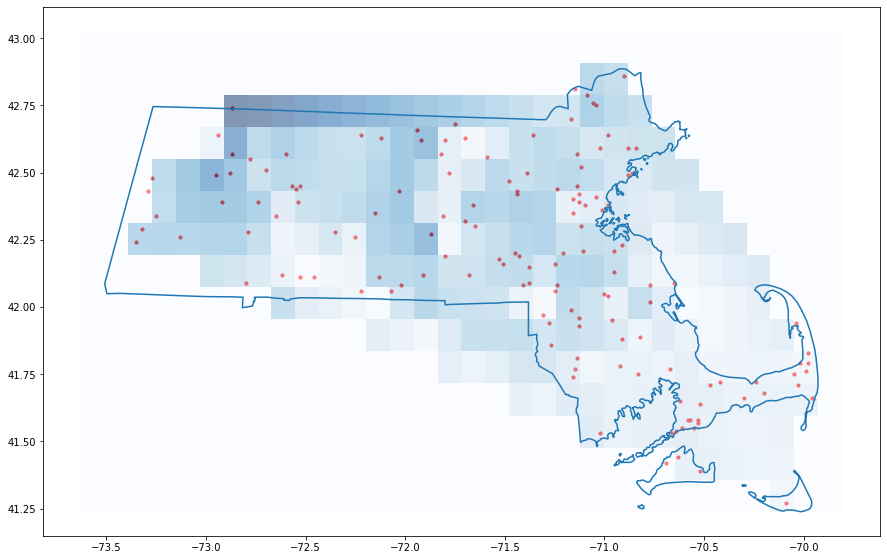

In [160]:
mass_plot = MA.boundary.plot(figsize=(15,15))
snow_stations.plot(ax=mass_plot, color="red", markersize=10)
get_interp_cell_df(30,"linear").plot(ax=mass_plot, cmap="Blues", column='snowfall', alpha=0.5)

In [161]:
def get_clipped_interp_cell_df(n_cells, method):
    cell = get_interp_cell_df(n_cells, method)
    return gpd.clip(cell, MA)

<AxesSubplot:>

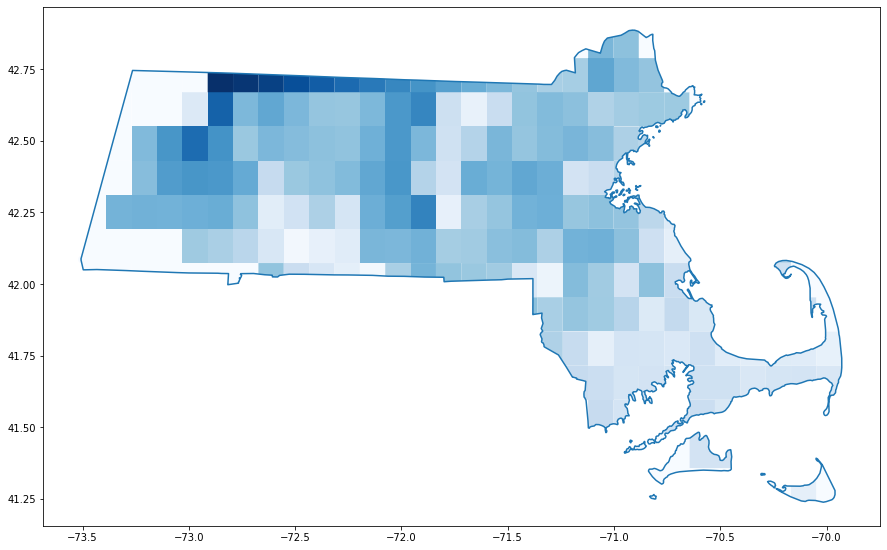

In [162]:
mass_plot = MA.boundary.plot(figsize=(15,15))
get_clipped_interp_cell_df(30, "linear").plot(ax=mass_plot, cmap="Blues", column='snowfall', alpha=1)

<AxesSubplot:>

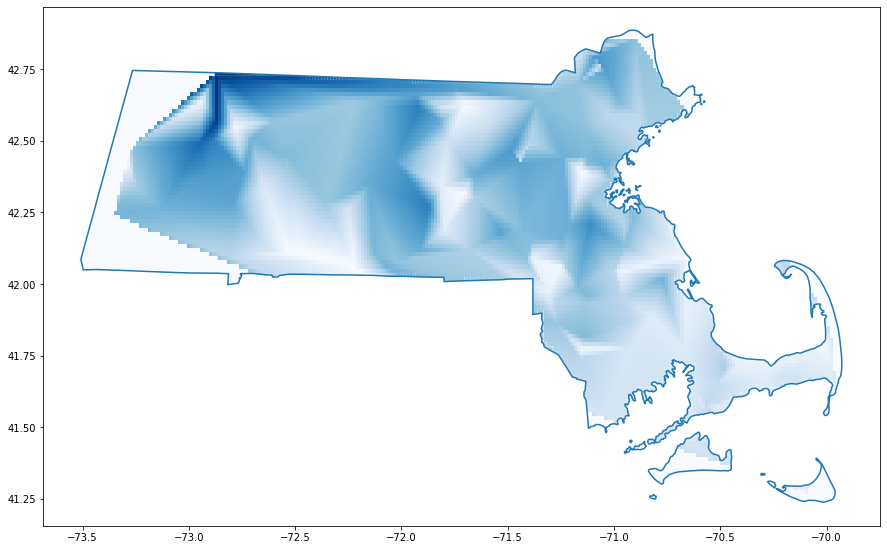

In [163]:
mass_plot = MA.boundary.plot(figsize=(15,15))
get_clipped_interp_cell_df(250, "linear").plot(ax=mass_plot, cmap="Blues", column='snowfall', alpha=1)

<AxesSubplot:>

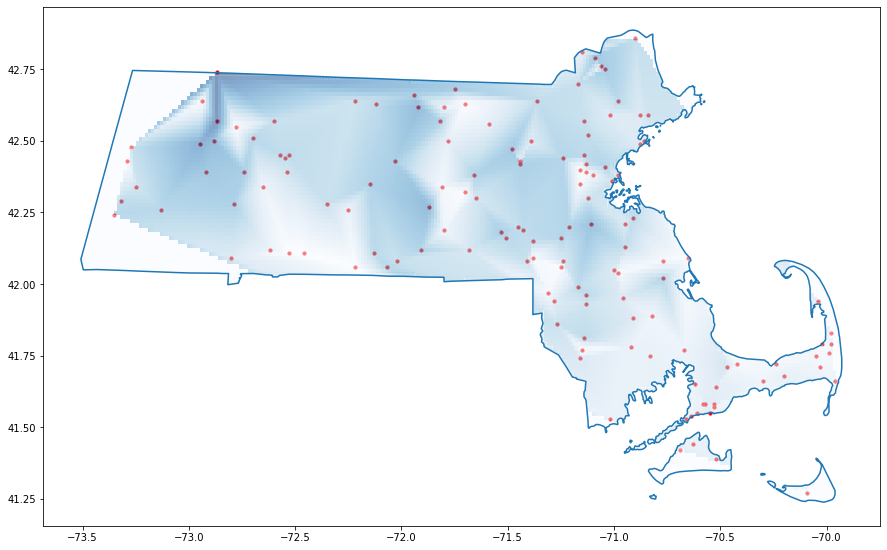

In [164]:
mass_plot = MA.boundary.plot(figsize=(15,15))
snow_stations.plot(ax=mass_plot, color="red", markersize=10)
get_clipped_interp_cell_df(250, "linear").plot(ax=mass_plot, cmap="Blues", column='snowfall', alpha=0.5)

## Technical Question
How do different styles of interpolation impact the resulting visuals?

<AxesSubplot:>

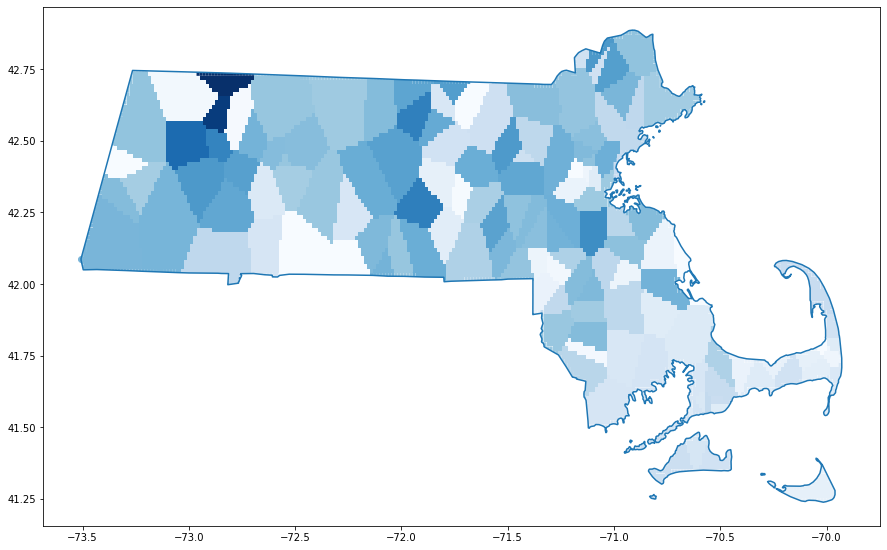

In [165]:
mass_plot = MA.boundary.plot(figsize=(15,15))
get_clipped_interp_cell_df(250, "nearest").plot(ax=mass_plot, cmap="Blues", column='snowfall', alpha=1)

<AxesSubplot:>

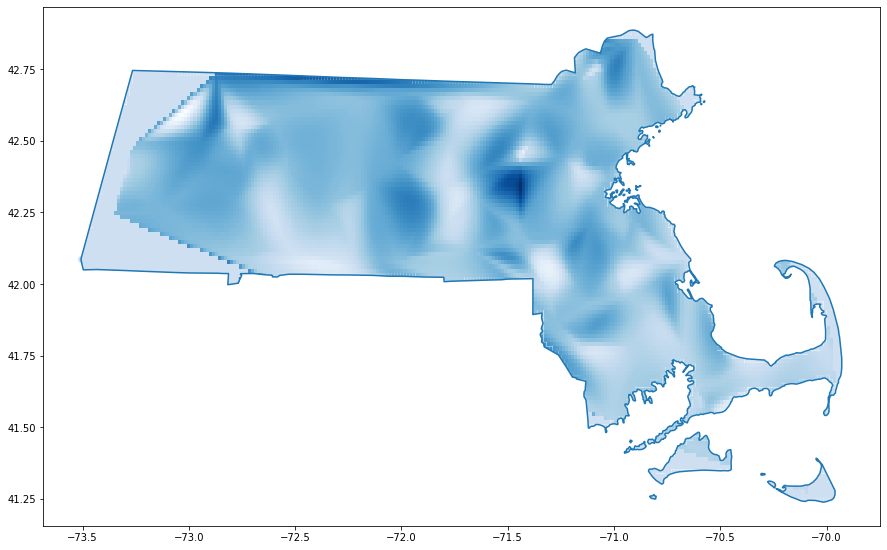

In [166]:
mass_plot = MA.boundary.plot(figsize=(15,15))
get_clipped_interp_cell_df(250, "cubic").plot(ax=mass_plot, cmap="Blues", column='snowfall', alpha=1)

<AxesSubplot:>

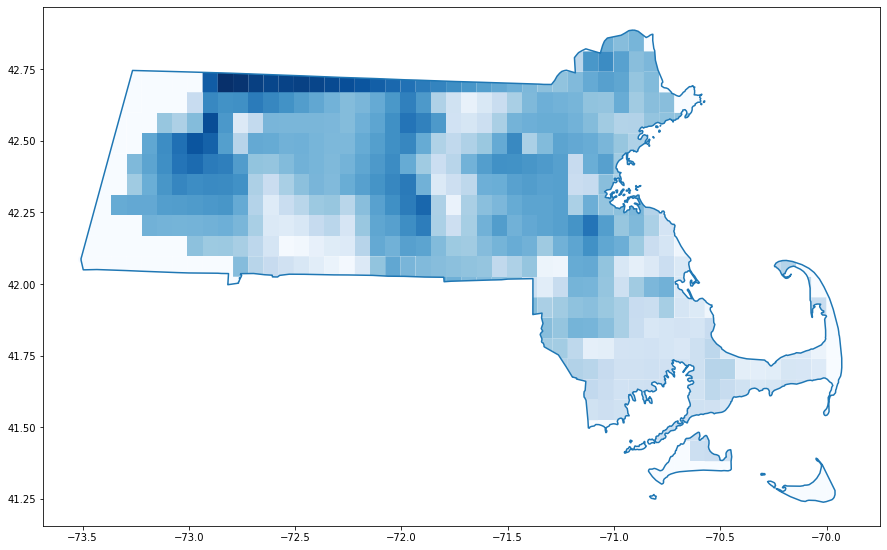

In [169]:
mass_plot = MA.boundary.plot(figsize=(15,15))
get_clipped_interp_cell_df(50, "linear").plot(ax=mass_plot, cmap="Blues", column='snowfall', alpha=1)

## What We've Seen
The coastal areas have the least snowfall, with Cape Cod having nearly no snowfall.  
The more mountainous areas have more snowfall, with the appalachian area accumualting heavy snowfall.  
The more northern areas have more snowfall

## Next Steps
Overlay terrian maps and average temperature maps, see if they match up with snowfall map.  
Break down specific months or years and see if there is an impact on snowfall.  
Draw more specific connections between the landscape and the snowfall accumulation.